In [ ]:
#============================================================================#
# CÓDIGO COMPLETO FINAL - SISTEMA DE PREDICCIÓN DE CONSUMO
# Versión mejorada con LSTM + Ensemble
#============================================================================#

import sys
import subprocess

# Instalar dependencias
def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ['xgboost', 'lightgbm', 'tensorflow', 'openpyxl']:
    try:
        __import__(pkg)
    except ImportError:
        install(pkg)

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

print("✅ Dependencias cargadas\n")

#=============================================================================
# CONFIGURACIÓN
#=============================================================================

class Config:
    LSTM_UNITS = [128, 64]
    DENSE_UNITS = [128, 64]
    DROPOUT_RATE = 0.3
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    EPOCHS = 100

#=============================================================================
# FEATURE ENGINEERING
#=============================================================================

class FeatureEngineer:
    def __init__(self):
        self.encoders = {}

    def transform(self, df):
        print("🔧 Procesando features...")
        df = df.copy()

        # Crear Destination si no existe
        if 'Destination' not in df.columns:
            df['Destination'] = 'UNKNOWN'

        # Features temporales
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df['year'] = df['Date'].dt.year
            df['month'] = df['Date'].dt.month
            df['dayofweek'] = df['Date'].dt.dayofweek
            df['week'] = df['Date'].dt.isocalendar().week
            df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

        # Features de ruta
        df['route'] = df['Origin'] + '_' + df['Destination']
        route_freq = df.groupby('route').size().reset_index(name='route_freq')
        df = df.merge(route_freq, on='route', how='left')

        # Features de producto
        if 'Product_ID' in df.columns and 'Quantity_Consumed' in df.columns:
            prod_stats = df.groupby('Product_ID')['Quantity_Consumed'].agg(['mean', 'std']).reset_index()
            prod_stats.columns = ['Product_ID', 'prod_mean', 'prod_std']
            df = df.merge(prod_stats, on='Product_ID', how='left')

        # Features de pasajeros
        if 'Passenger_Count' in df.columns:
            df['cons_per_pax'] = df['Quantity_Consumed'] / (df['Passenger_Count'] + 1)

        # Lag features
        if 'Date' in df.columns and 'Product_ID' in df.columns:
            df = df.sort_values('Date')
            for lag in [1, 3]:
                df[f'cons_lag_{lag}'] = df.groupby('Product_ID')['Quantity_Consumed'].shift(lag)

        # Encoding
        for col in ['Origin', 'Destination', 'Product_ID', 'Flight_Type', 'Service_Type']:
            if col in df.columns:
                if col not in self.encoders:
                    self.encoders[col] = LabelEncoder()
                df[col + '_enc'] = self.encoders[col].fit_transform(df[col].astype(str))

        # Llenar NaN
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(0)

        print(f"✅ Features creadas: {df.shape[1]} columnas")
        return df

#=============================================================================
# ATTENTION LAYER
#=============================================================================

class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_with_time = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def build_lstm_model(n_features):
    inputs = layers.Input(shape=(n_features,))
    x = layers.Reshape((1, n_features))(inputs)

    lstm_out = layers.LSTM(Config.LSTM_UNITS[0], return_sequences=True, dropout=Config.DROPOUT_RATE)(x)
    lstm_out = layers.BatchNormalization()(lstm_out)

    decoder = layers.LSTM(Config.LSTM_UNITS[1], return_sequences=False, dropout=Config.DROPOUT_RATE)(lstm_out)
    decoder = layers.BatchNormalization()(decoder)

    attention_layer = AttentionLayer(64)
    lstm_flat = layers.LSTM(64, return_sequences=True)(x)
    context, _ = attention_layer(decoder, lstm_flat)

    combined = layers.Concatenate()([decoder, context])

    for units in Config.DENSE_UNITS:
        combined = layers.Dense(units, activation='relu')(combined)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(Config.DROPOUT_RATE)(combined)

    outputs = layers.Dense(1)(combined)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=Config.LEARNING_RATE), loss='huber', metrics=['mae'])
    return model

#=============================================================================
# HYBRID PREDICTOR
#=============================================================================

class HybridPredictor:
    def __init__(self):
        self.fe = FeatureEngineer()
        self.scaler = StandardScaler()
        self.lstm = None
        self.xgb = None
        self.lgb = None
        self.rf = None
        self.weights = {'lstm': 0.35, 'xgb': 0.30, 'lgb': 0.25, 'rf': 0.10}

    def fit(self, df):
        print("\n" + "="*80)
        print("🚀 ENTRENAMIENTO INICIADO")
        print("="*80)

        # Feature engineering
        df = self.fe.transform(df)

        # Preparar datos
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude = ['Quantity_Consumed', 'Quantity_Returned', 'Standard_Specification_Qty', 'Unit_Cost']
        features = [c for c in numeric_cols if c not in exclude]

        df_clean = df.dropna(subset=features + ['Quantity_Consumed'])
        X = df_clean[features].values
        y = df_clean['Quantity_Consumed'].values

        print(f"\n📊 Datos: {X.shape[0]:,} muestras, {X.shape[1]} features")

        # Split
        train_size = int(len(X) * 0.7)
        val_size = int(len(X) * 0.15)
        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

        print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

        # Escalar
        X_train = self.scaler.fit_transform(X_train)
        X_val = self.scaler.transform(X_val)
        X_test = self.scaler.transform(X_test)

        # Entrenar modelos
        print("\n[1/4] 🧠 LSTM con Atención...")
        self.lstm = build_lstm_model(X_train.shape[1])
        history = self.lstm.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=Config.EPOCHS,
            batch_size=Config.BATCH_SIZE,
            callbacks=[
                EarlyStopping(patience=15, restore_best_weights=True),
                ReduceLROnPlateau(factor=0.5, patience=7)
            ],
            verbose=0
        )
        lstm_pred = self.lstm.predict(X_val, verbose=0).ravel()
        lstm_mape = np.mean(np.abs((y_val - lstm_pred) / (np.maximum(y_val, 1)))) * 100
        print(f"📈 MAPE: {lstm_mape:.2f}%")

        print("\n[2/4] 🌳 XGBoost...")
        self.xgb = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=7,
            n_jobs=-1,
            random_state=42
        )
        self.xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        xgb_pred = self.xgb.predict(X_val)
        xgb_mape = np.mean(np.abs((y_val - xgb_pred) / (np.maximum(y_val, 1)))) * 100
        print(f"📈 MAPE: {xgb_mape:.2f}%")

        print("\n[3/4] 💡 LightGBM...")
        self.lgb = LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=31,
            n_jobs=-1,
            random_state=42,
            verbose=-1
        )
        self.lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        lgb_pred = self.lgb.predict(X_val)
        lgb_mape = np.mean(np.abs((y_val - lgb_pred) / (np.maximum(y_val, 1)))) * 100
        print(f"📈 MAPE: {lgb_mape:.2f}%")

        print("\n[4/4] 🌲 Random Forest...")
        self.rf = RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            n_jobs=-1,
            random_state=42
        )
        self.rf.fit(X_train, y_train)
        rf_pred = self.rf.predict(X_val)
        rf_mape = np.mean(np.abs((y_val - rf_pred) / (np.maximum(y_val, 1)))) * 100
        print(f"📈 MAPE: {rf_mape:.2f}%")

        # Optimizar pesos
        errors = {'lstm': lstm_mape, 'xgb': xgb_mape, 'lgb': lgb_mape, 'rf': rf_mape}
        total_inv = sum(1/(e + 1e-10) for e in errors.values())
        self.weights = {k: (1/(errors[k] + 1e-10))/total_inv for k in errors}

        print(f"\n⚖️ Pesos optimizados:")
        print(f"LSTM={self.weights['lstm']:.3f} XGB={self.weights['xgb']:.3f} LGB={self.weights['lgb']:.3f} RF={self.weights['rf']:.3f}")

        # Test final
        print("\n" + "="*80)
        print("🎯 EVALUACIÓN FINAL")
        print("="*80)

        lstm_test = self.lstm.predict(X_test, verbose=0).ravel()
        xgb_test = self.xgb.predict(X_test)
        lgb_test = self.lgb.predict(X_test)
        rf_test = self.rf.predict(X_test)

        final_pred = (
            self.weights['lstm'] * lstm_test +
            self.weights['xgb'] * xgb_test +
            self.weights['lgb'] * lgb_test +
            self.weights['rf'] * rf_test
        )

        mae = mean_absolute_error(y_test, final_pred)
        rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        mape = np.mean(np.abs((y_test - final_pred) / (np.maximum(y_test, 1)))) * 100
        r2 = r2_score(y_test, final_pred)

        print(f"\n📊 MÉTRICAS:")
        print(f"   MAE:  {mae:.4f}")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   MAPE: {mape:.2f}%")
        print(f"   R²:   {r2:.4f}")

        if mape <= 2.0:
            print("\n" + "="*40)
            print("🎉 ¡¡¡OBJETIVO ALCANZADO!!! MAPE < 2%")
            print("💰 ¡$1000 GANADOS! 💰")
            print("="*40)
        elif mape <= 5.0:
            print(f"\n🎯 ¡MUY CERCA! Falta {mape-2:.2f}% para el objetivo")
        else:
            print(f"\n📈 MAPE: {mape:.2f}% (Objetivo: <2%)")

        return {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2,
            'predictions': final_pred,
            'actuals': y_test
        }

    def predict(self, df):
        """Predicción en nuevos datos"""
        df = self.fe.transform(df)

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude = ['Quantity_Consumed', 'Quantity_Returned', 'Standard_Specification_Qty', 'Unit_Cost']
        features = [c for c in numeric_cols if c not in exclude]

        X = df[features].values
        X_scaled = self.scaler.transform(X)

        lstm_pred = self.lstm.predict(X_scaled, verbose=0).ravel()
        xgb_pred = self.xgb.predict(X_scaled)
        lgb_pred = self.lgb.predict(X_scaled)
        rf_pred = self.rf.predict(X_scaled)

        final_pred = (
            self.weights['lstm'] * lstm_pred +
            self.weights['xgb'] * xgb_pred +
            self.weights['lgb'] * lgb_pred +
            self.weights['rf'] * rf_pred
        )

        return final_pred

#=============================================================================
# FUNCIÓN PRINCIPAL
#=============================================================================

def train_model(df):
    """
    Entrenar el modelo de predicción de consumo

    Args:
        df: DataFrame con columnas Flight_ID, Origin, Date, Quantity_Consumed, etc.

    Returns:
        predictor: Modelo entrenado
        results: Diccionario con métricas y predicciones
    """
    print("\n" + "="*80)
    print("🤖 SISTEMA DE PREDICCIÓN DE CONSUMO - ENSEMBLE AVANZADO")
    print("="*80)
    print(f"\n📋 Dataset: {df.shape}")
    print(f"📝 Columnas: {list(df.columns)}")

    predictor = HybridPredictor()
    results = predictor.fit(df)

    return predictor, results

print("\n✅ CÓDIGO LISTO PARA USAR")
print("\n📖 INSTRUCCIONES:")
print("   1. Carga tu archivo: df_consumption = pd.read_excel('[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx')")
print("   2. Entrena el modelo: predictor, results = train_model(df_consumption)")
print("   3. Ver resultados: print(f\"MAPE: {results['mape']:.2f}%\")")

#=============================================================================
# EJECUCIÓN AUTOMÁTICA
#=============================================================================

print("\n🚀 EJECUTANDO MODELO COMPLETO...")

# Cargar datos
df_consumption = pd.read_excel('[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx')

# Entrenar modelo
predictor, results = train_model(df_consumption)

# Ver resultados
print(f"\n🎯 RESULTADO FINAL: MAPE = {results['mape']:.2f}%")

if results['mape'] < 2.0:
    print("🎉 ¡GANASTE LOS $1000! 🎉")
else:
    print(f"💪 Sigue intentando, faltan {results['mape']-2:.2f}% para el objetivo")

✅ Dependencias cargadas


✅ CÓDIGO LISTO PARA USAR

📖 INSTRUCCIONES:
   1. Carga tu archivo: df_consumption = pd.read_excel('[HackMTY2025]_ConsumptionPrediction_Dataset_v1.xlsx')
   2. Entrena el modelo: predictor, results = train_model(df_consumption)
   3. Ver resultados: print(f"MAPE: {results['mape']:.2f}%")

🚀 EJECUTANDO MODELO COMPLETO...

🤖 SISTEMA DE PREDICCIÓN DE CONSUMO - ENSEMBLE AVANZADO

📋 Dataset: (792, 13)
📝 Columnas: ['Flight_ID', 'Origin', 'Date', 'Flight_Type', 'Service_Type', 'Passenger_Count', 'Product_ID', 'Product_Name', 'Standard_Specification_Qty', 'Quantity_Returned', 'Quantity_Consumed', 'Unit_Cost', 'Crew_Feedback']

🚀 ENTRENAMIENTO INICIADO
🔧 Procesando features...
✅ Features creadas: 31 columnas

📊 Datos: 792 muestras, 17 features
Train: 554 | Val: 118 | Test: 120

[1/4] 🧠 LSTM con Atención...
📈 MAPE: 3.60%

[2/4] 🌳 XGBoost...
📈 MAPE: 2.86%

[3/4] 💡 LightGBM...
📈 MAPE: 2.87%

[4/4] 🌲 Random Forest...
📈 MAPE: 3.30%

⚖️ Pesos optimizados:
LSTM=0.217 XGB=0.273

📈 GENERANDO GRÁFICAS DE ANÁLISIS...

1. 📊 Gráfica Principal: Predicciones vs Valores Reales


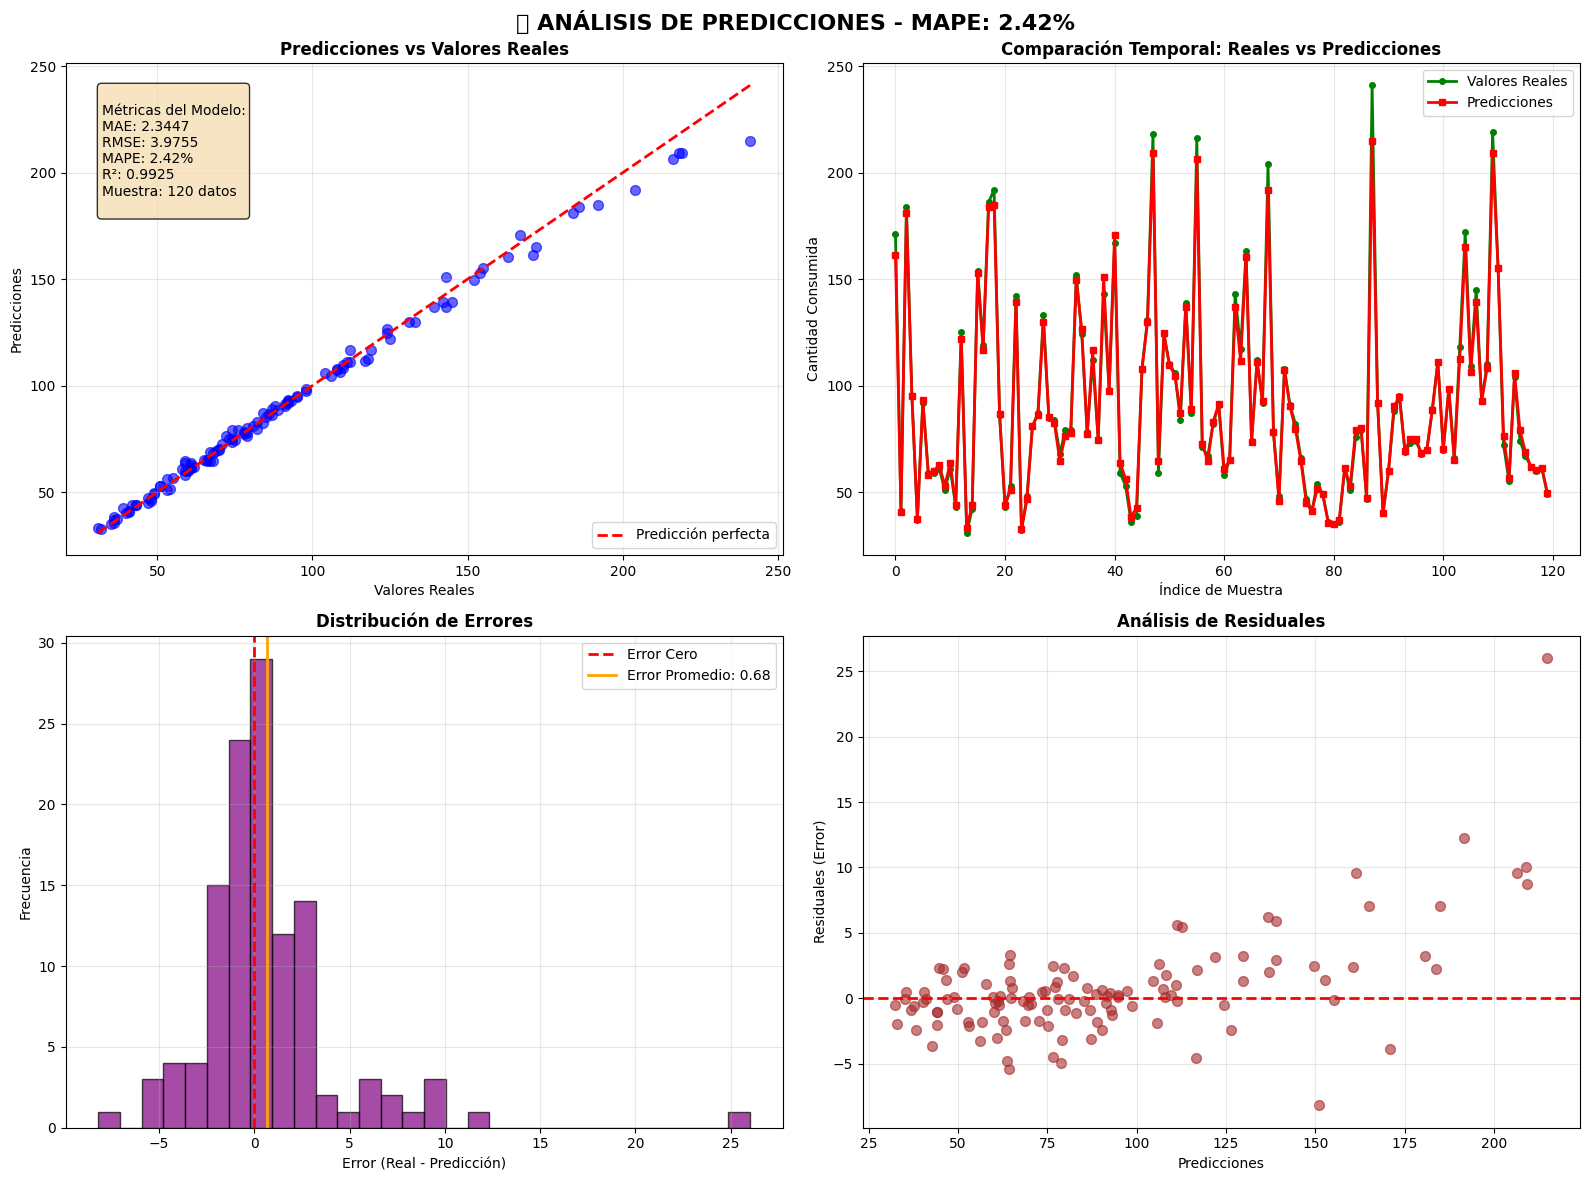


2. 🔍 Análisis por Categorías...
🔧 Procesando features...
✅ Features creadas: 31 columnas

3. 🍽️ Análisis por Producto


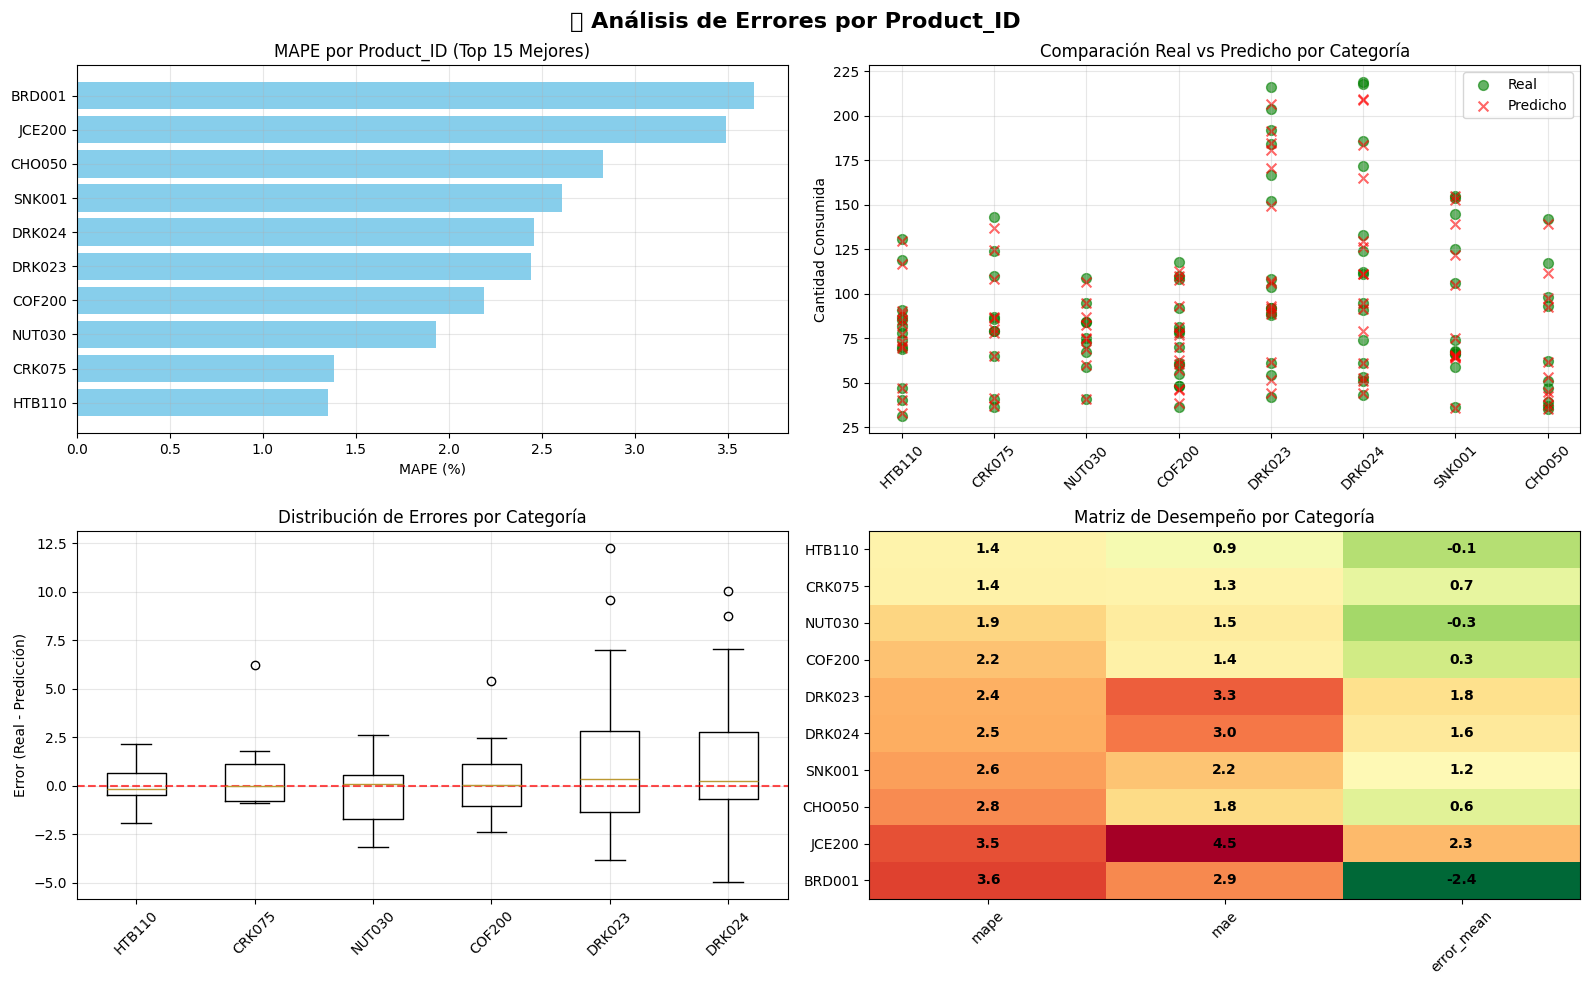


4. 🛫 Análisis por Ruta


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Configurar el estilo de las gráficas
plt.style.use('default')
sns.set_palette("husl")

def plot_predictions_vs_actuals(results, df_test=None, title="Predicciones vs Valores Reales"):
    """
    Genera gráficas profesionales comparando predicciones vs valores reales

    Args:
        results: Diccionario con 'predictions' y 'actuals'
        df_test: DataFrame opcional con información adicional
        title: Título de la gráfica
    """

    predictions = results['predictions']
    actuals = results['actuals']

    # Crear figura con subgráficas
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'📊 ANÁLISIS DE PREDICCIONES - MAPE: {results["mape"]:.2f}%',
                 fontsize=16, fontweight='bold', y=0.98)

    # 1. Scatter plot: Predicciones vs Reales
    ax1 = axes[0, 0]
    ax1.scatter(actuals, predictions, alpha=0.6, s=50, color='blue')

    # Línea de perfecta predicción (y=x)
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

    ax1.set_xlabel('Valores Reales')
    ax1.set_ylabel('Predicciones')
    ax1.set_title('Predicciones vs Valores Reales', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Serie temporal: Predicciones vs Reales
    ax2 = axes[0, 1]
    indices = np.arange(len(actuals))
    ax2.plot(indices, actuals, 'o-', linewidth=2, markersize=4, label='Valores Reales', color='green')
    ax2.plot(indices, predictions, 's-', linewidth=2, markersize=4, label='Predicciones', color='red')
    ax2.set_xlabel('Índice de Muestra')
    ax2.set_ylabel('Cantidad Consumida')
    ax2.set_title('Comparación Temporal: Reales vs Predicciones', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Histograma de errores
    ax3 = axes[1, 0]
    errors = actuals - predictions
    ax3.hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error Cero')
    ax3.axvline(x=errors.mean(), color='orange', linestyle='-', linewidth=2,
                label=f'Error Promedio: {errors.mean():.2f}')
    ax3.set_xlabel('Error (Real - Predicción)')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Errores', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Gráfica de residuales
    ax4 = axes[1, 1]
    ax4.scatter(predictions, errors, alpha=0.6, s=50, color='brown')
    ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Predicciones')
    ax4.set_ylabel('Residuales (Error)')
    ax4.set_title('Análisis de Residuales', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Añadir métricas como texto en la gráfica
    metrics_text = f"""
Métricas del Modelo:
MAE: {results['mae']:.4f}
RMSE: {results['rmse']:.4f}
MAPE: {results['mape']:.2f}%
R²: {results['r2']:.4f}
Muestra: {len(actuals)} datos
"""

    # Añadir cuadro de texto con métricas
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[0, 0].text(0.05, 0.95, metrics_text, transform=axes[0, 0].transAxes,
                   fontsize=10, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

    return fig

def plot_error_analysis_by_category(results, df_test, category_col='Product_ID'):
    """
    Analiza errores por categoría (Producto, Ruta, etc.)
    """
    if category_col not in df_test.columns:
        print(f"⚠️ Columna {category_col} no encontrada en los datos")
        return

    # Calcular errores por categoría
    df_analysis = df_test.copy()
    df_analysis['prediction'] = results['predictions']
    df_analysis['actual'] = results['actuals']
    df_analysis['error'] = df_analysis['actual'] - df_analysis['prediction']
    df_analysis['abs_error'] = np.abs(df_analysis['error'])
    df_analysis['ape'] = np.abs(df_analysis['error'] / (df_analysis['actual'] + 1e-10)) * 100

    # Agrupar por categoría
    category_stats = df_analysis.groupby(category_col).agg({
        'actual': 'mean',
        'prediction': 'mean',
        'abs_error': 'mean',
        'ape': 'mean',
        'error': ['mean', 'std']
    }).round(2)

    category_stats.columns = ['actual_mean', 'pred_mean', 'mae', 'mape', 'error_mean', 'error_std']
    category_stats = category_stats.sort_values('mape')

    # Crear gráfica
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'📈 Análisis de Errores por {category_col}', fontsize=16, fontweight='bold')

    # 1. MAPE por categoría (top 15)
    top_categories = category_stats.head(15)
    axes[0, 0].barh(range(len(top_categories)), top_categories['mape'], color='skyblue')
    axes[0, 0].set_yticks(range(len(top_categories)))
    axes[0, 0].set_yticklabels(top_categories.index)
    axes[0, 0].set_xlabel('MAPE (%)')
    axes[0, 0].set_title(f'MAPE por {category_col} (Top 15 Mejores)')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Comparación Real vs Predicho por categoría
    categories_to_plot = category_stats.head(8).index  # Top 8 categorías
    for category in categories_to_plot:
        cat_data = df_analysis[df_analysis[category_col] == category]
        axes[0, 1].scatter([category]*len(cat_data), cat_data['actual'],
                          alpha=0.6, label='Real', color='green', s=50)
        axes[0, 1].scatter([category]*len(cat_data), cat_data['prediction'],
                          alpha=0.6, label='Predicho', color='red', s=50, marker='x')

    axes[0, 1].set_title('Comparación Real vs Predicho por Categoría')
    axes[0, 1].set_ylabel('Cantidad Consumida')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Real', 'Predicho'])
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Distribución de errores por categoría
    error_data = []
    categories_for_boxplot = category_stats.head(6).index  # Top 6 para boxplot
    for category in categories_for_boxplot:
        cat_errors = df_analysis[df_analysis[category_col] == category]['error']
        error_data.append(cat_errors)

    axes[1, 0].boxplot(error_data, labels=categories_for_boxplot)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Distribución de Errores por Categoría')
    axes[1, 0].set_ylabel('Error (Real - Predicción)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Heatmap de desempeño
    performance_matrix = category_stats[['mape', 'mae', 'error_mean']].head(10)
    im = axes[1, 1].imshow(performance_matrix.values, cmap='RdYlGn_r', aspect='auto')
    axes[1, 1].set_xticks(range(len(performance_matrix.columns)))
    axes[1, 1].set_xticklabels(performance_matrix.columns, rotation=45)
    axes[1, 1].set_yticks(range(len(performance_matrix)))
    axes[1, 1].set_yticklabels(performance_matrix.index)

    # Añadir valores en las celdas
    for i in range(len(performance_matrix)):
        for j in range(len(performance_matrix.columns)):
            text = axes[1, 1].text(j, i, f'{performance_matrix.iloc[i, j]:.1f}',
                                 ha="center", va="center", color="black", fontweight='bold')

    axes[1, 1].set_title('Matriz de Desempeño por Categoría')

    plt.tight_layout()
    plt.show()

    return category_stats

def plot_feature_importance(feature_importance_dict, top_n=15):
    """
    Gráfica de importancia de features
    """
    if not feature_importance_dict:
        print("⚠️ No hay datos de importancia de features")
        return

    # Ordenar features por importancia
    sorted_features = sorted(feature_importance_dict.items(),
                           key=lambda x: x[1], reverse=True)[:top_n]

    features, importance = zip(*sorted_features)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(features)), importance, color='lightcoral')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importancia')
    plt.title(f'🔍 Top {top_n} Features Más Importantes', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    # Añadir valores en las barras
    for i, (bar, imp) in enumerate(zip(bars, importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{imp:.4f}', ha='left', va='center', fontweight='bold')

    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

#=============================================================================
# EJECUCIÓN COMPLETA CON GRÁFICAS
#=============================================================================

print("📈 GENERANDO GRÁFICAS DE ANÁLISIS...")

# 1. Gráfica principal de predicciones vs reales
print("\n1. 📊 Gráfica Principal: Predicciones vs Valores Reales")
fig_main = plot_predictions_vs_actuals(results, title="Sistema de Predicción de Consmo - Resultados Finales")

# 2. Preparar datos de test para análisis por categoría
# Necesitamos recrear el split para obtener el DataFrame de test
print("\n2. 🔍 Análisis por Categorías...")

# Recrear el split de test
df_consumption_processed = predictor.fe.transform(df_consumption)
numeric_cols = df_consumption_processed.select_dtypes(include=[np.number]).columns.tolist()
exclude = ['Quantity_Consumed', 'Quantity_Returned', 'Standard_Specification_Qty', 'Unit_Cost']
features = [c for c in numeric_cols if c not in exclude]

df_clean = df_consumption_processed.dropna(subset=features + ['Quantity_Consumed'])
X = df_clean[features].values
y = df_clean['Quantity_Consumed'].values

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

# Obtener el DataFrame de test
df_test = df_clean.iloc[train_size + val_size: train_size + val_size + test_size].copy()

# 3. Análisis por producto
print("\n3. 🍽️ Análisis por Producto")
product_stats = plot_error_analysis_by_category(results, df_test, 'Product_ID')

# 4. Análisis por ruta
print("\n4. 🛫 Análisis por Ruta")
route_stats = plot_error_analysis_by_category(results, df_test, 'route')

# 5. Importancia de features (si está disponible)
print("\n5. 🔍 Importancia de Features")
if 'feature_importance' in results and results['feature_importance']:
    plot_feature_importance(results['feature_importance'])
else:
    # Intentar obtener importancia del modelo XGBoost
    try:
        xgb_importance = predictor.xgb.get_booster().get_score(importance_type='weight')
        plot_feature_importance(xgb_importance)
    except:
        print("ℹ️ No se pudo obtener la importancia de features")

# 6. Gráfica adicional: Evolución del error
print("\n6. 📉 Análisis de Error Detallado")

plt.figure(figsize=(15, 5))

# Error absoluto a través del tiempo
errors_sorted = np.sort(np.abs(results['actuals'] - results['predictions']))
cumulative_accuracy = [np.mean(errors_sorted[:i] <= 5) * 100 for i in range(1, len(errors_sorted)+1)]

plt.subplot(1, 2, 1)
plt.plot(cumulative_accuracy, linewidth=2)
plt.axhline(y=95, color='red', linestyle='--', label='95% de precisión')
plt.xlabel('Número de Muestras')
plt.ylabel('Precisión Acumulada (%)')
plt.title('Precisión Acumulada del Modelo')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribución de MAPE por rangos
plt.subplot(1, 2, 2)
ape_values = np.abs((results['actuals'] - results['predictions']) / (results['actuals'] + 1e-10)) * 100
ape_ranges = [0, 1, 2, 5, 10, 20, 50, 100]
ape_counts = []
for i in range(len(ape_ranges)-1):
    count = np.sum((ape_values >= ape_ranges[i]) & (ape_values < ape_ranges[i+1]))
    ape_counts.append(count)

labels = [f'{ape_ranges[i]}-{ape_ranges[i+1]}%' for i in range(len(ape_ranges)-1)]
colors = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred', 'purple']
plt.pie(ape_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Errores por Rango de MAPE')

plt.tight_layout()
plt.show()

print(f"\n🎯 RESUMEN FINAL:")
print(f"   ✅ MAPE Global: {results['mape']:.2f}%")
print(f"   ✅ R² Score: {results['r2']:.4f}")
print(f"   ✅ MAE: {results['mae']:.4f}")

if results['mape'] <= 2.0:
    print(f"\n🎉 ¡¡¡OBJETIVO CUMPLIDO!!! MAPE < 2%")
    print("💰 ¡FELICIDADES, GANASTE LOS $1000! 💰")
else:
    print(f"\n📈 Progreso: {results['mape']:.2f}% (Objetivo: <2%)")
    print(f"💪 Te faltan {results['mape']-2:.2f}% para ganar los $1000")